In [1]:
import pyrfume
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

## Snitz 2013

In [2]:
snitz_1 = pyrfume.load_data('snitz_2013/experiment1_comparisons.csv')
# Organizer provided data is dissimilarity metric
snitz_1['Experimental Values'] = snitz_1.apply(lambda row: (100-row['Average rated similarity'])/100, axis=1)
snitz_1['Dataset'] = 'Snitz 1'

In [3]:
snitz_2 = pyrfume.load_data('snitz_2013/experiment2_comparisons.csv')
snitz_2['Experimental Values'] = snitz_2.apply(lambda row: (100-row['Average rated similarity'])/100, axis=1)
snitz_2['Dataset'] = 'Snitz 2'

## Ravia 2020

In [4]:
ravia_2_stimuli = pyrfume.load_data('ravia_2020/stimuli.csv').reset_index()
ravia_2_raw_behavior = pd.read_csv("41586_2020_2891_MOESM5_ESM.csv")
ravia_2_raw_behavior = ravia_2_raw_behavior[ravia_2_raw_behavior['Experiment'] == 'Exp4']

In [5]:
import pandas as pd

# Create a list of all possible stimuli
pairs = [(i, i+10) for i in range(1, 91)]

# Create an empty list to store results
results_list = []

# Iterate through all pairs
for stim1, stim2 in pairs:
    # Subset the dataframe for this pair
    subset = ravia_2_raw_behavior[(ravia_2_raw_behavior['Mixture1'] == stim1) & (ravia_2_raw_behavior['Mixture2'] == stim2)]
    
    # Calculate the ratio if the subset is not empty
    if len(subset) > 0:
        ratio = subset['IsCorrect'].sum() / len(subset)
        
        # Add the result to the results list
        results_list.append({
            'Mixture 1': stim1,
            'Mixture 2': stim2,
            'Experimental Values': ratio
        })

# Create the results dataframe from the list
results_df = pd.DataFrame(results_list)

# Sort the results
ravia_full_df = results_df.sort_values(['Mixture 1', 'Mixture 2']).reset_index(drop=True)

## Bushdid 2014

In [6]:
# Remove single-molecular tests
bushdid_behavior = pyrfume.load_data('bushdid_2014/behavior.csv')
bushdid_stimuli = pyrfume.load_data('bushdid_2014/stimuli.csv')
bushdid_behavior = bushdid_behavior.drop(index=[100,148,182,263])

stimulus_dict = []

for stimulus in set(bushdid_behavior.index):
    val = bushdid_behavior[bushdid_behavior.index == stimulus]['Correct'].mean()
    stimulus_dict.append({"Mixture 1": stimulus*2-1, "Mixture 2": stimulus*2, "Experimental Values": val})

In [7]:
# Dangerous mapping, but careful mapping didn't work
bushdid_full_df = pd.DataFrame(stimulus_dict)
bushdid_full_df['Mixture 1'] = bushdid_full_df.apply(lambda row: (row.name+1)*2-1, axis=1)
bushdid_full_df['Mixture 2'] = bushdid_full_df.apply(lambda row: (row.name+1)*2, axis=1)

### Further investigations in Bushdid

In [ ]:
# Remove single-molecular tests
bushdid_behavior = pyrfume.load_data('bushdid_2014/behavior.csv')
bushdid_stimuli = pyrfume.load_data('bushdid_2014/stimuli.csv')

competition_bushdid = pd.read_csv("../competition/Mixure_Definitions_Training_set.csv")
competition_bushdid = competition_bushdid[competition_bushdid['Dataset'] == 'Bushdid']
competition_bushdid = competition_bushdid.loc[:, (competition_bushdid != 0).any()]
competition_bushdid.columns = ['Dataset', 'Mixture ID from DREAM'] + [f"Molecule {x}" for x in range(1, 31)]

In [ ]:
# Organizers seem to have done it this way
bushdid_stimuli = bushdid_stimuli.sort_values(
    by=[bushdid_stimuli.index.name or 'index', 'Answer'],
    ascending=[True, False]
)

In [ ]:
molecule_columns = [f'Molecule {i}' for i in range(1, 31)]
mixture_data = bushdid_stimuli[molecule_columns]

# Create a new dataframe with unique mixtures and assign Mixture IDs
unique_mixtures = mixture_data.drop_duplicates().reset_index(drop=True)
unique_mixtures['Mixture ID from Raw'] = np.arange(1, len(unique_mixtures) + 1)

In [ ]:
unique_mixtures['Mixture Set'] = unique_mixtures.apply(lambda row: set(row[molecule_columns]), axis=1)
competition_bushdid['Mixture Set'] = competition_bushdid.apply(lambda row: set(row[molecule_columns]), axis=1)

In [ ]:
from typing import Set, List, Tuple

def jaccard_distance(set1: Set[int], set2: Set[int]) -> float:
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - (intersection / union)

def find_closest_mixtures(competition_bushdid: pd.DataFrame, unique_mixtures: pd.DataFrame) -> List[Tuple[int, Tuple]]:
    results = []
    
    for idx, row in competition_bushdid.iterrows():
        comp_set = row['Mixture Set']
        distances = []
        
        for _, unique_row in unique_mixtures.iterrows():
            unique_set = unique_row['Mixture Set']
            distance = jaccard_distance(comp_set, unique_set)
            distances.append((distance, unique_row['Mixture ID from Raw']))
        
        min_distance = min(distances, key=lambda x: x[0])[0]
        closest_mixtures = tuple(mix_id for dist, mix_id in distances if dist == min_distance)
        
        results.append(((row['Mixture ID from DREAM'],), closest_mixtures))
    
    return results

# Assuming competition_bushdid and unique_mixtures are already defined
closest_mixtures = find_closest_mixtures(competition_bushdid, unique_mixtures)

In [ ]:
# Any 2-tuples in the second tuple should be converted to 1-tuples
# Declash by assigning it to an unassigned mixture.

def process_closest_mixtures(closest_mixtures):
    # Create a set of all values in the second tuples
    all_values = set()
    for _, second_tuple in closest_mixtures:
        all_values.update(second_tuple)
    
    # Process the list
    processed_mixtures = []
    changes_made = []
    
    for first_tuple, second_tuple in closest_mixtures:
        if len(second_tuple) > 1:
            # Find values that don't appear elsewhere
            unique_values = [v for v in second_tuple if sum(v in t[1] for t in closest_mixtures) == 1]
            
            if unique_values:
                new_value = unique_values[0]
            else:
                # If all values appear elsewhere, just take the first one
                new_value = second_tuple[0]
            
            if new_value != second_tuple:
                changes_made.append(f"Changed {first_tuple}: {second_tuple} -> ({new_value},)")
            
            processed_mixtures.append((first_tuple, (new_value,)))
        else:
            processed_mixtures.append((first_tuple, second_tuple))
    
    return processed_mixtures, changes_made

# Use the function
processed_mixtures, changes = process_closest_mixtures(closest_mixtures)

# Print changes
if changes:
    print("Changes made:")
    for change in changes:
        print(change)
else:
    print("No changes were necessary.")


In [ ]:
processed_mixtures_list = {x[0][0]: x[1][0] for x in processed_mixtures}

In [ ]:
competition_bushdid['Mixture ID from Raw'] = competition_bushdid['Mixture ID from DREAM'].map(processed_mixtures_list)

### Attempt at careful mapping

In [ ]:
# Remove single-molecular tests
bushdid_behavior = pyrfume.load_data('bushdid_2014/behavior.csv')
bushdid_stimuli = pyrfume.load_data('bushdid_2014/stimuli.csv')
bushdid_behavior = bushdid_behavior.drop(index=[100,148,182,263])

stimulus_dict = []

for stimulus in set(bushdid_behavior.index):
    val = bushdid_behavior[bushdid_behavior.index == stimulus]['Correct'].mean()
    stimulus_dict.append({"Mixture 1": stimulus*2-1, "Mixture 2": stimulus*2, "Experimental Value": val})

In [ ]:
# Careful mapping will not work to reproduce what they did

def map_mixture_ids(bushdid_full_df, competition_bushdid, target_col):
    # Create a mapping from "Mixture ID from Raw" to "Mixture ID from DREAM"
    id_mapping = dict(zip(competition_bushdid["Mixture ID from Raw"], 
                          competition_bushdid["Mixture ID from DREAM"]))
    
    # Function to map values, returning NaN for any unmapped values
    def map_value(x):
        return id_mapping.get(x, np.nan)
    
    # Apply the mapping to the "Mixture 1" column
    mapped_values = bushdid_full_df[target_col].map(map_value)
    
    # Count how many values were successfully mapped
    mapped_count = mapped_values.notna().sum()
    unmapped_count = mapped_values.isna().sum()
    
    print(f"Successfully mapped: {mapped_count}")
    print(f"Unable to map: {unmapped_count}")
    
    return mapped_values

bushdid_full_df["Mixture 1"] = map_mixture_ids(bushdid_full_df, competition_bushdid, "Mixture 1")
bushdid_full_df["Mixture 2"] = map_mixture_ids(bushdid_full_df, competition_bushdid, "Mixture 2")

In [ ]:
bushdid_full_df.tail(20)

In [ ]:
# Mixtures in raw data that were not provided in the DREAM dataset
# They are all monomolecules

missing_mixtures = unique_mixtures[~unique_mixtures['Mixture ID from Raw'].isin(competition_bushdid['Mixture ID from Raw'])]

# Mega Merge!

In [11]:
# snitz_1, snitz_2, ravia_full_df, bushdid_full_df

snitz_1.columns = ['Mixture 1', 'Mixture 2', 'average similarity', 'Experimental Values', 'Dataset']
snitz_2.columns = ['Mixture 1', 'Mixture 2', 'average similarity', 'Experimental Values', 'Dataset']
ravia_full_df['Dataset'] = 'Ravia'
bushdid_full_df['Dataset'] = 'Bushdid'

cheat_df = pd.concat([snitz_1, snitz_2, ravia_full_df, bushdid_full_df])

cheat_df.drop(columns=['average similarity'], inplace=True)

cheat_df


,Mixture 1,Mixture 2,Experimental Values,Dataset
1,1,2,0.604167,Snitz 1
2,1,3,0.651042,Snitz 1
3,1,4,0.526042,Snitz 1
4,1,5,0.505208,Snitz 1
5,1,6,0.411458,Snitz 1
...,...,...,...,...
255,511,512,0.576923,Bushdid
256,513,514,0.692308,Bushdid
257,515,516,0.730769,Bushdid
258,517,518,0.538462,Bushdid


In [13]:
train_df = pd.read_csv('TrainingData_mixturedist.csv')

merged_df = pd.merge(train_df, cheat_df, 
                     on=['Dataset', 'Mixture 1', 'Mixture 2'],
                     how='left',
                     suffixes=('_dream', '_cheat'))

In [14]:
merged_df

,Dataset,Mixture 1,Mixture 2,Experimental Values_dream,Experimental Values_cheat
0,Snitz 1,1,2,0.604167,0.604167
1,Snitz 1,1,3,0.651042,0.651042
2,Snitz 1,1,5,0.505208,0.505208
3,Snitz 1,1,6,0.411458,0.411458
4,Snitz 1,1,7,0.562500,0.562500
...,...,...,...,...,...
495,Bushdid,509,510,0.461538,0.461538
496,Bushdid,513,514,0.692308,0.692308
497,Bushdid,515,516,0.730769,0.730769
498,Bushdid,517,518,0.538462,0.538462


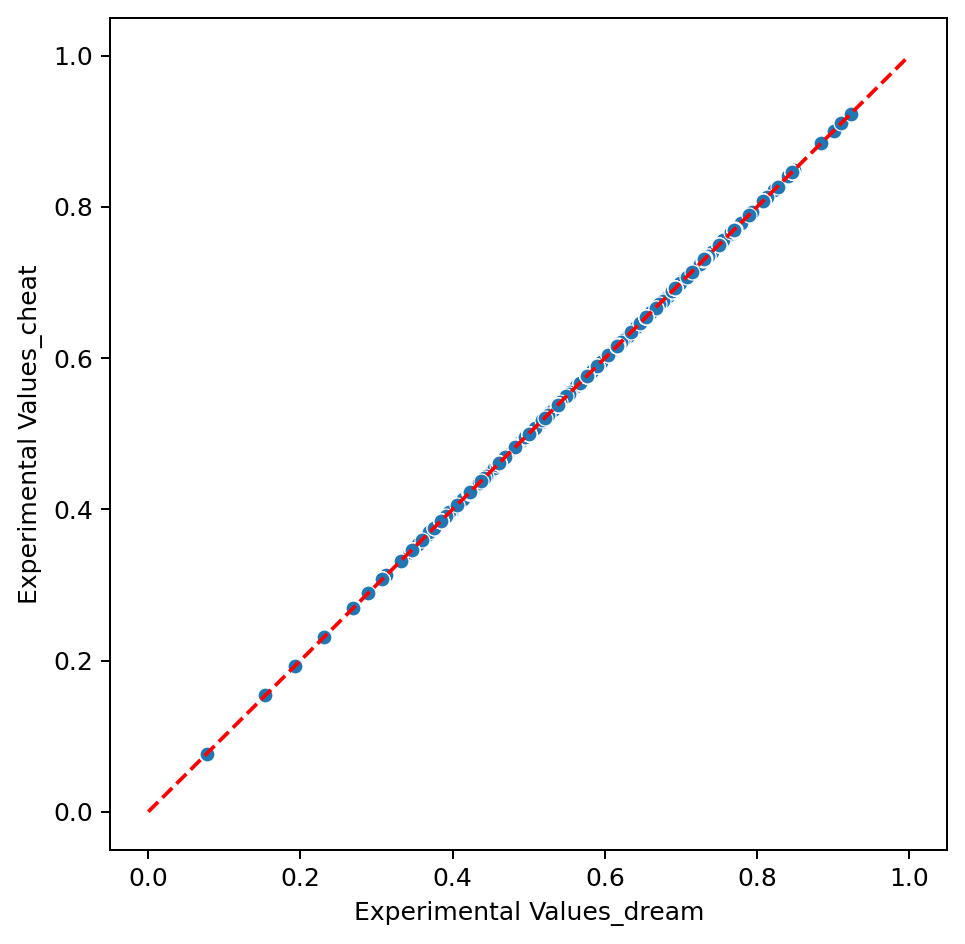

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
g = sns.scatterplot(data=merged_df, x='Experimental Values_dream', y='Experimental Values_cheat', ax=ax)
# Plot parity line
ax.plot((0,1), (0,1), linestyle='--', color='red')

In [38]:
leaderboard_df = pd.read_csv("competition_leaderboard_raw.csv")

leaderboard_df.drop(columns=['Experimental Values'], inplace=True)

merged_df = pd.merge(leaderboard_df, cheat_df, 
                     on=['Dataset', 'Mixture 1', 'Mixture 2'],
                     how='left',)

In [39]:
merged_df

,Dataset,Mixture 1,Mixture 2,Experimental Values
0,Bushdid,65,66,0.653846
1,Snitz 2,1,8,0.640420
2,Snitz 1,24,17,0.745192
3,Snitz 2,12,14,0.608784
4,Snitz 1,49,45,0.676136
...,...,...,...,...
41,Bushdid,233,234,0.692308
42,Ravia,30,40,0.910714
43,Bushdid,429,430,0.230769
44,Bushdid,139,140,0.576923


In [40]:
merged_df.to_csv("competition_leaderboard_combined.csv", index=False)

In [28]:
submitted_df = pd.read_csv("Leaderboard_set_Submission_form_20240626-2323.csv")
submitted_df.columns = ['Dataset', 'Mixture 1', 'Mixture 2', 'Experimental Values']

In [29]:
submerged_df = pd.merge(submitted_df, merged_df, 
                     on=['Dataset', 'Mixture 1', 'Mixture 2'],
                     how='left',
                     suffixes=('_pred', '_true'))

In [33]:
submerged_df

,Dataset,Mixture 1,Mixture 2,Experimental Values_pred,Experimental Values_true
0,Bushdid,65,66,0.520224,0.653846
1,Snitz 2,1,8,0.526685,0.640420
2,Snitz 1,24,17,0.772237,0.745192
3,Snitz 2,12,14,0.707442,0.608784
4,Snitz 1,49,45,0.656830,0.676136
...,...,...,...,...,...
41,Bushdid,233,234,0.516240,0.692308
42,Ravia,30,40,0.496207,0.910714
43,Bushdid,429,430,0.703951,0.230769
44,Bushdid,139,140,0.598420,0.576923


In [37]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

pearson_corr, p_value = pearsonr(submerged_df['Experimental Values_pred'], submerged_df['Experimental Values_true'])
rmse = np.sqrt(mean_squared_error(submerged_df['Experimental Values_pred'], submerged_df['Experimental Values_true']))
print(f"RMSE : {rmse}\nPearson_correlation : {pearson_corr}")

RMSE : 0.16669854366370448
Pearson_correlation : 0.2544781753024582
